### 1. Data Cleaning and Preprocessing

- Workflow:

1. Split your data into train and test sets.
2. Drop, Impute missing values (fit on train, transform test).
3. Select features (fit on train, apply to test).
4. Scale numerical features (fit on train, transform test).
5. Encode categorical features (fit on train, transform test).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define Random State
RANDOM_STATE = 42

#### 1.1 Find Missing Values

#### Note : Some variables contains negative values, this indicate missing data that need to be processed

In [2]:
df = pd.read_csv("s3://ml-feature-store-029552764749/credit_fraud/data/fraud_1.csv")
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.9,0.990415,11,4,40,0.014640,-0.897718,AC,1853,...,0,200.0,0,INTERNET,6.150317,windows,0,1,0,0
1,0,0.4,0.781728,-1,151,30,0.013269,11.501507,AA,5447,...,0,1500.0,0,INTERNET,4.521952,windows,1,1,0,0
2,0,0.7,0.274290,-1,92,20,0.010669,23.943928,AA,2312,...,0,200.0,0,INTERNET,8.361707,other,1,1,0,0
3,0,0.9,0.722684,-1,55,20,0.021849,48.202774,AA,2413,...,0,1500.0,0,INTERNET,7.339743,other,0,1,0,0
4,0,0.9,0.121661,-1,51,20,0.021491,-1.602116,AB,1227,...,0,1500.0,0,INTERNET,4.338063,other,0,1,0,0


In [3]:
columns_to_check = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 
                    'session_length_in_minutes', 'device_distinct_emails_8w']  

# Convert negative value to nan
df[columns_to_check] = df[columns_to_check].where(df[columns_to_check] >= 0, np.nan)

##### Columns with 70% of their value missing

In [5]:
missing_ratio = df.isnull().sum() / len(df)        
missing_ratio[missing_ratio > 0.7].index.tolist()

['prev_address_months_count', 'intended_balcon_amount']

In [6]:
df.isnull().sum()

fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           704367
current_address_months_count          4442
customer_age                             0
days_since_request                       0
intended_balcon_amount              739988
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                        0
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   254905
has_other_cards                          0
proposed_cr

#### Draw box plot of all missing data

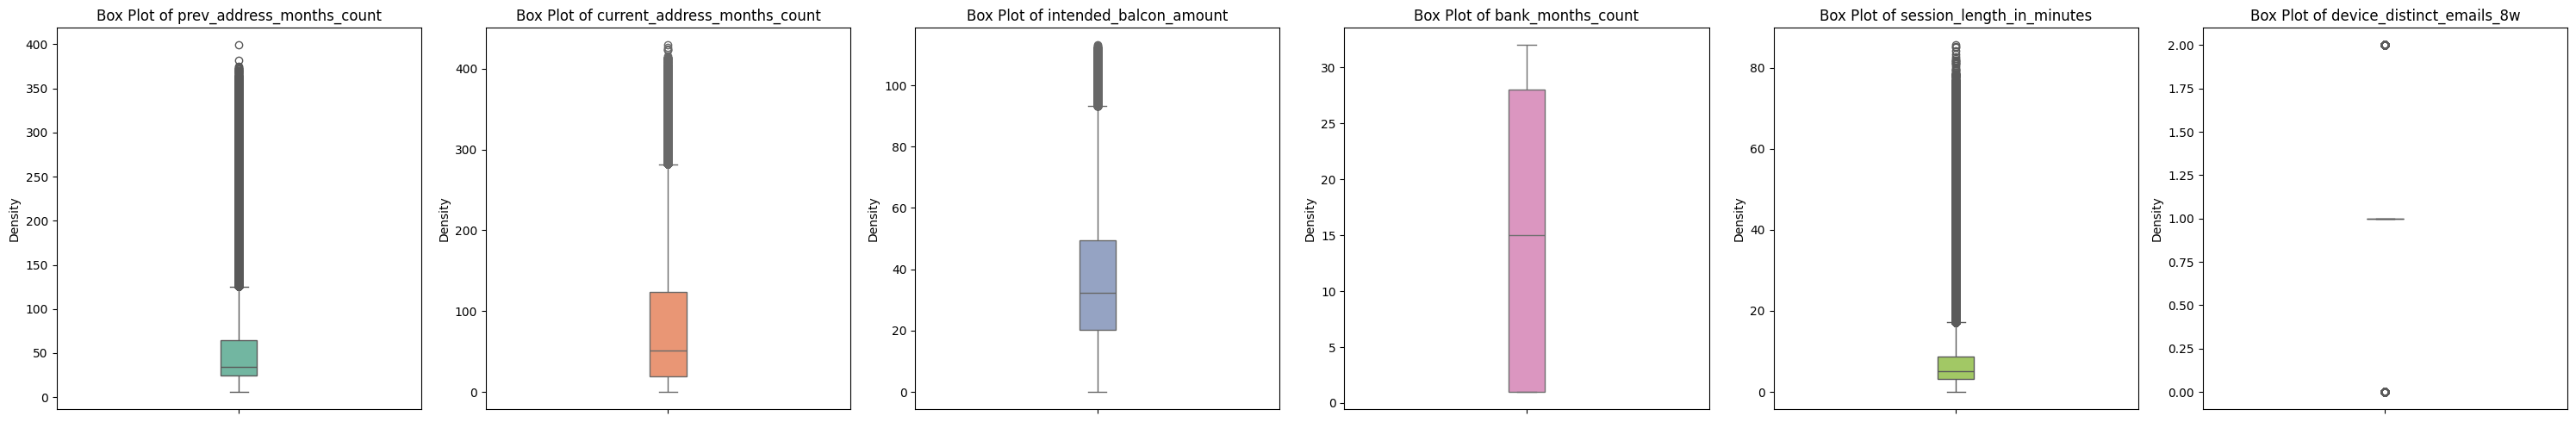

In [7]:
df_missing = df[['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 
                 'device_distinct_emails_8w']]

# Create box plots for multiple features
# Determine the number of features
num_features = len(df_missing.columns)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(num_features * 5, 5))

# Ensure axes is iterable
if num_features == 1:
    axes = [axes]

# Define a color palette
colors = sns.color_palette('Set2', num_features)

# Loop through each feature
for i, (ax, column) in enumerate(zip(axes, df_missing.columns)):
    # Plot the KDE plot
    #sns.kdeplot(data=df_missing[column], ax=ax, color=colors[i], fill=True, alpha=0.3)
    
    # Add the box plot on the same axes
    sns.boxplot(y=df_missing[column], ax=ax, width=0.1, color=colors[i])

    ax.set_title(f'Box Plot of {column}')
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

#### Insights
- Filling NA:
    - **device_distinct_emails_8w**: SimpleImputer(strategy='most_frequent')
    - **session_length_in_minutes**: SimpleImputer(strategy='median')
    - **intended_balcon_amount**: consider dropping (High percentage of missing in a feature)
    - **current_address_months_count**: SimpleImputer(strategy='median') (outliers)
    - **prev_address_months_count**: consider dropping (High percentage of missing in a feature)

- Scaling, encoding: 
    - **device_distinct_emails_8w**: One-Hot Encoding (nominal categorical)
    - **session_length_in_minutes**: Robust Scaling (outliers)
    - **intended_balcon_amount**: consider dropping (High percentage of missing in a feature)
    - **current_address_months_count**: Robust Scaling (outliers)
    - **prev_address_months_count**: consider dropping (High percentage of missing in a feature)

#### Dropping features 
- Drop value with high percentage of missing

In [8]:
#drop intended_balcon_amount and prev_address_months_count
df.drop(['prev_address_months_count', 'intended_balcon_amount', 'device_fraud_count'], axis=1, inplace=True)
df.shape

(1000000, 29)

## 2. Data Preprocessing

##### Split your dataset BEFORE fitting any preprocessing to avoid data leakage

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

In [10]:
X_train.shape, X_test.shape


((800000, 28), (200000, 28))

In [11]:
# Define feature types

num_features = [
        "income", "name_email_similarity", "current_address_months_count",
        "customer_age", "days_since_request", "zip_count_4w", "velocity_6h",
        "velocity_24h", "velocity_4w", "bank_branch_count_8w",
        "date_of_birth_distinct_emails_4w", "credit_risk_score",
        "bank_months_count", "proposed_credit_limit",
        "session_length_in_minutes", "device_distinct_emails_8w", "month",
    ]


cat_features = [
        "payment_type", "employment_status", "housing_status", "source",
        "device_os", "email_is_free", "phone_home_valid",
        "phone_mobile_valid", "has_other_cards", "foreign_request",
        
        ]



print(f"Number of numerical features: {len(num_features)}")
print(f"Number of categorical features: {len(cat_features)}")       

df[num_features]

Number of numerical features: 17
Number of categorical features: 10


,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month
0,0.9,0.990415,4.0,40,0.014640,1853,6711.523027,4868.779488,4988.827961,0,19,113,NaN,200.0,6.150317,1.0,0
1,0.4,0.781728,151.0,30,0.013269,5447,8948.772349,5824.765506,6451.180606,16,14,83,5.0,1500.0,4.521952,1.0,0
2,0.7,0.274290,92.0,20,0.010669,2312,11727.292100,7679.867045,6731.304261,1351,15,70,28.0,200.0,8.361707,1.0,0
3,0.9,0.722684,55.0,20,0.021849,2413,4126.145203,4458.366351,6356.833258,30,8,222,20.0,1500.0,7.339743,1.0,0
4,0.9,0.121661,51.0,20,0.021491,1227,9730.276231,5544.081678,6721.196241,505,12,126,1.0,1500.0,4.338063,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.9,0.173671,110.0,30,0.004057,979,1290.193422,3509.677630,3696.222287,6,5,217,25.0,200.0,5.740367,1.0,7
999996,0.9,0.566285,29.0,50,0.014215,1190,1244.988645,2476.158833,3136.372338,14,3,212,1.0,200.0,26.319296,1.0,7
999997,0.6,0.807476,164.0,30,0.040160,1571,4452.976672,3441.533927,3009.209161,16,4,185,25.0,1000.0,1.614444,1.0,7
999998,0.8,0.151376,12.0,30,0.016871,1435,2989.280984,2846.053283,3004.093680,1,10,142,NaN,200.0,3.682591,1.0,7


### 2.1 Filling missing value using SimpletImputer

In [12]:
from sklearn.impute import SimpleImputer

##### Median imputation is preferred when the distribution is skewed

In [13]:
# a. Impute Numerical Features

num_imputer = SimpleImputer(strategy="median")

# Fit the imputer on the training data
num_imputer.fit(X_train[num_features])

# Transform both training and test data
X_train_numeric = pd.DataFrame(
    num_imputer.transform(X_train[num_features]),
    columns=num_features,
    index=X_train.index
)

X_test_numeric = pd.DataFrame(
    num_imputer.transform(X_test[num_features]),
    columns=num_features,
    index=X_test.index
)


In [14]:
# b. Impute Categorical
# Initialize the imputer for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the training data
categorical_imputer.fit(X_train[cat_features])

# Transform both training and test data
X_train_categorical = pd.DataFrame(
    categorical_imputer.transform(X_train[cat_features]),
    columns=cat_features,
    index=X_train.index
)

X_test_categorical = pd.DataFrame(
    categorical_imputer.transform(X_test[cat_features]),
    columns=cat_features,
    index=X_test.index
)


In [15]:
# Combine numerical and categorical features and binary features
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_test_imputed = pd.concat([X_test_numeric, X_test_categorical], axis=1)

print("Imputed Training Data:")
X_train_imputed.head()

# print("\nImputed Test Data:")
# print(X_test_imputed.head())

Imputed Training Data:


,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,payment_type,employment_status,housing_status,source,device_os,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request
39067,0.1,0.754015,36.0,30.0,0.003672,2602.0,4663.026888,4256.962394,6379.542660,732.0,...,AA,CA,BC,INTERNET,linux,1,0,1,0,0
822675,0.9,0.230411,115.0,40.0,0.020899,808.0,7587.134717,4026.475119,4344.400191,0.0,...,AB,CB,BC,INTERNET,other,0,1,1,1,0
914427,0.1,0.611803,111.0,20.0,0.012643,874.0,5529.530254,3028.941069,3077.985496,1.0,...,AC,CA,BE,INTERNET,other,1,0,1,0,0
581316,0.9,0.393472,185.0,20.0,3.217992,2431.0,2215.750401,3607.207578,4954.087127,1.0,...,AC,CA,BE,INTERNET,windows,1,0,1,0,0
603125,0.4,0.437082,8.0,30.0,0.007311,1779.0,5883.125540,3357.761415,5075.613790,7.0,...,AB,CF,BB,INTERNET,linux,0,0,0,0,0


##### Let's check if we have clean the data completely

In [17]:
X_train_imputed.isna().sum()

income                              0
name_email_similarity               0
current_address_months_count        0
customer_age                        0
days_since_request                  0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
credit_risk_score                   0
bank_months_count                   0
proposed_credit_limit               0
session_length_in_minutes           0
device_distinct_emails_8w           0
month                               0
payment_type                        0
employment_status                   0
housing_status                      0
source                              0
device_os                           0
email_is_free                       0
phone_home_valid                    0
phone_mobile_valid                  0
has_other_cards                     0
foreign_requ

- No more misssing value

### 2.2 Data Scalling and Encoding

In [18]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [22]:
# a. Scale Numerical Features
# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training data
scaler.fit(X_train_imputed[num_features])

# Transform both training and test data
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_imputed[num_features]),
    columns=num_features,
    index=X_train_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed[num_features]),
    columns=num_features,
    index=X_test_imputed.index
)

In [23]:
# b. Encode Categorical Features
# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder on the training data
encoder.fit(X_train_imputed[cat_features])

# Transform both training and test data
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train_imputed[cat_features]),
    columns=encoder.get_feature_names_out(cat_features),
    index=X_train_imputed.index
)

X_test_encoded = pd.DataFrame(
    encoder.transform(X_test_imputed[cat_features]),
    columns=encoder.get_feature_names_out(cat_features),
    index=X_test_imputed.index
)


In [24]:
X_train_encoded.shape, X_train_scaled.shape

((800000, 36), (800000, 17))

In [26]:
# Combine scaled numerical and encoded categorical features
X_train_preprocessed = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_test_preprocessed = pd.concat([X_test_scaled, X_test_encoded], axis=1)

print("Processed Training Data:")
X_train_preprocessed.describe()

Processed Training Data:


,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,email_is_free_0,email_is_free_1,phone_home_valid_0,phone_home_valid_1,phone_mobile_valid_0,phone_mobile_valid_1,has_other_cards_0,has_other_cards_1,foreign_request_0,foreign_request_1
count,800000.000000,8.000000e+05,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,...,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.00000,800000.00000
mean,-0.078224,4.353857e-03,0.312352,0.099159,5.457662e+01,0.288764,0.085251,0.010216,-0.046345,7.487571,...,0.469074,0.530926,0.600181,0.399819,0.101576,0.898424,0.781716,0.218284,0.97511,0.02489
std,0.580723,5.458789e-01,0.821416,0.545086,2.881041e+02,0.948539,0.707129,0.683734,0.754235,19.897935,...,0.499043,0.499043,0.489861,0.489861,0.302090,0.302090,0.413081,0.413081,0.15579,0.15579
min,-1.000000,-9.303328e-01,-0.485714,-1.000000,-7.933077e-01,-1.197356,-1.285453,-1.579568,-1.688427,-0.391304,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,-0.600000,-5.020386e-01,-0.304762,-0.500000,-4.182054e-01,-0.355052,-0.438281,-0.534694,-0.528545,-0.347826,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.00000
50%,0.000000,5.245336e-17,0.000000,0.000000,4.556338e-17,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.00000
75%,0.400000,4.979614e-01,0.695238,0.500000,5.817946e-01,0.644948,0.561719,0.465306,0.471455,0.652174,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.00000
max,0.600000,9.594955e-01,3.600000,3.000000,4.024920e+03,5.107649,2.704805,2.213631,1.687264,103.347826,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


- We have finished scalling and encoding the data

## 3. Model Trainning

#### We will perform sampling technique such as NearMiss or SMOTE to address class imbalance. 

In [28]:
# Imbalanced-learn for NearMiss and Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

#Grid SearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Scoring
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

#Model
from lightgbm import LGBMClassifier as lgb
from sklearn.linear_model import LogisticRegression


Both methods address class imbalance but in opposite ways:

- **NearMiss (Under-sampling):** Reduces the majority class samples, only keep the most informative instances.
- **SMOTE (Over-sampling):** Increases the minority class by generating synthetic samples, creating new instances along the feature space between existing minority samples.


#### Sampling

#### Let's try to compare the performance of undersampling and oversampling with our baseline model logistic regression

In [29]:
near_miss_obj = NearMiss()
smote_obj = SMOTE()
#smoteen_obj = SMOTEENN()

X_train_over, y_train_res_over = smote_obj.fit_resample(X_train_preprocessed, y_train.ravel())
X_train_under, y_train_res_under = near_miss_obj.fit_resample(X_train_preprocessed, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res_over.shape))
print('After UnderSampling, the shape of train_X: {}'.format(X_train_under.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_res_under.shape))

/var/folders/rq/29s55l_x6y97hf1zppzzshpw0000gn/T/ipykernel_34586/2332181103.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_over, y_train_res_over = smote_obj.fit_resample(X_train_preprocessed, y_train.ravel())
/var/folders/rq/29s55l_x6y97hf1zppzzshpw0000gn/T/ipykernel_34586/2332181103.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_under, y_train_res_under = near_miss_obj.fit_resample(X_train_preprocessed, y_train.ravel())


After OverSampling, the shape of train_X: (1582354, 53)
After OverSampling, the shape of train_y: (1582354,) 

After UnderSampling, the shape of train_X: (17646, 53)
After UnderSampling, the shape of train_y: (17646,) 



In [ ]:
logis_smote_model = LogisticRegression(max_iter = 100, solver="saga", random_state=RANDOM_STATE)
logis_smote_model.fit(X_train_over, y_train_res_over)

logis_nearmiss_model = logis_model = LogisticRegression(max_iter = 100, random_state=RANDOM_STATE)
logis_nearmiss_model.fit(X_train_under, y_train_res_under)

In [ ]:
y_pred_logis_smote = logis_smote_model.predict(X_test_preprocessed)
smote_report = classification_report(y_test, y_pred_logis_smote)
print(f"Classification Report for Logistic Regression with Oversampling:\n{smote_report}")

y_pred_logis_nearmiss = logis_nearmiss_model.predict(X_test_preprocessed)
nearmiss_report = classification_report(y_test, y_pred_logis_nearmiss)
print(f"Classification Report for Logistic Regression with Undersampling:\n{nearmiss_report}")



Classification Report for Logistic Regression with Oversampling:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    197794
           1       0.04      0.73      0.08      2206

    accuracy                           0.82    200000
   macro avg       0.52      0.78      0.49    200000
weighted avg       0.99      0.82      0.89    200000

Classification Report for Logistic Regression with Undersampling:
              precision    recall  f1-score   support

           0       0.98      0.14      0.24    197794
           1       0.01      0.79      0.02      2206

    accuracy                           0.15    200000
   macro avg       0.50      0.46      0.13    200000
weighted avg       0.97      0.15      0.24    200000



#### Insights

**Oversampling**

- Oversampling performs **better overall**, with **higher accuracy** and a reasonable trade-off between recall and precision for the minority class.

**Undersampling**
- Undersampling struggles with majority class recall and precision while slightly improving minority class recall.


=> We will choose oversampling as our main sampling method

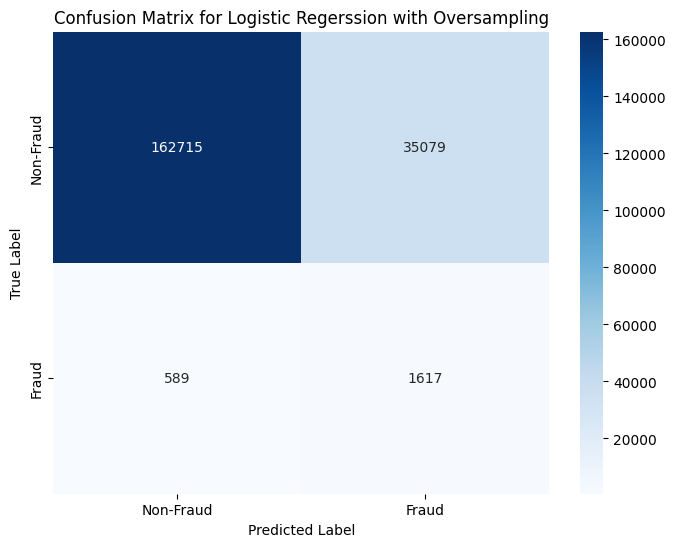

In [ ]:
cm_losgitic = confusion_matrix(y_test, y_pred_logis_smote)
# 5. Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_losgitic, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regerssion with Oversampling')
plt.show()  


In [ ]:
#predict probability
y_pred_prob = logis_smote_model.predict_proba(X_test_preprocessed)
# retrieve just the probabilities for the positive class
pos_probs = y_pred_prob[:, 1]


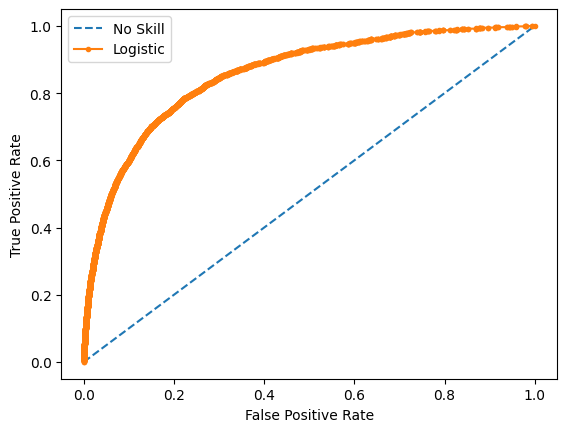

Logistic ROC AUC 0.857


In [ ]:
from matplotlib import pyplot
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
# calculate roc auc
roc_auc = roc_auc_score(y_test, pos_probs)
print('Logistic ROC AUC %.3f' % roc_auc)

An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class.

The x-axis indicates the False Positive Rate and the y-axis indicates the True Positive Rate.

source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

#### Let's try to fit different models and evaluate their performance

- For the sake of efficiency, I will try different models and chose the best model for hyperparameter tunning

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.over_sampling import SMOTE
import sys
import os

In [ ]:
models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "LightGBM": lgb(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter= 10000, random_state=42)
}

report = eval_models(X_train_preprocessed, y_train, X_test_preprocessed, y_test, models)


RandomForestClassifier - CV Mean: 0.8350, Test Score: 0.8448
[LightGBM] [Info] Number of positive: 791177, number of negative: 791177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6640
[LightGBM] [Info] Number of data points in the train set: 1582354, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM - CV Mean: 0.8670, Test Score: 0.8692
LogisticRegression - CV Mean: 0.8532, Test Score: 0.8569


#### LighGBM has the highest Test Score (0.8711), let's print out model metric and try to tune the model for better result!

In [ ]:
# Fit model with LightGBM
lgb_model = lgb(random_state=42)
lgb_model.fit(X_train_over, y_train_res_over)

[LightGBM] [Info] Number of positive: 791177, number of negative: 791177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6640
[LightGBM] [Info] Number of data points in the train set: 1582354, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [ ]:
#Predict
y_pred_lgb = lgb_model.predict(X_test_preprocessed)
lgb_report = classification_report(y_test, y_pred_lgb)
print(f"Classification Report for LightGBM with Oversampling:\n{lgb_report}")

Classification Report for LightGBM with Oversampling:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197794
           1       0.30      0.09      0.14      2206

    accuracy                           0.99    200000
   macro avg       0.64      0.54      0.56    200000
weighted avg       0.98      0.99      0.98    200000



#### Insights
- Recall score is very low, this is probably due to threshold at 0.5 is not optimal for imbalance test set, we need to lower threshold yo predict minority class better

#### Let's plot precision-recall curve for Positive class

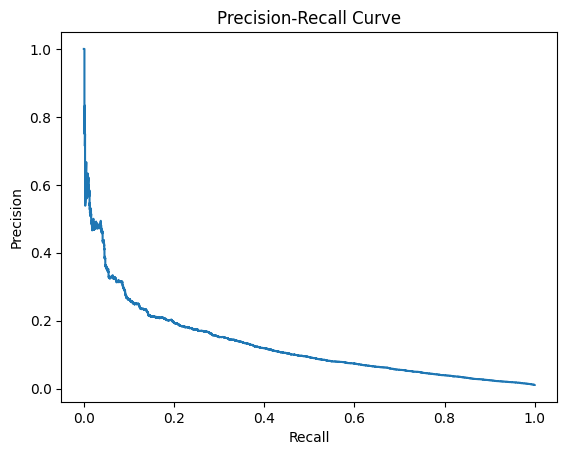

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred_probs = lgb_model.predict_proba(X_test_preprocessed)[:, 1]  # Predicted probabilities for the positive class
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot Precision-Recall curve
import matplotlib.pyplot as plt
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


#### insight
- We need higher recall (i.e., fewer false negatives) => might lower the threshold (e.g., from 0.5 down to 0.03). This typically **raises recall but drops precision**.

In [ ]:
optimal_threshold = 0.015  # Adjusting threshold
y_pred_adjusted = (y_pred_probs >= optimal_threshold).astype(int)

adjusted_report = classification_report(y_test, y_pred_adjusted)
print(f"Classification Report for LightGBM with Oversampling at 0.04 threshold:\n{adjusted_report}")


Classification Report for LightGBM with Oversampling at 0.04 threshold:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    197794
           1       0.04      0.81      0.08      2206

    accuracy                           0.79    200000
   macro avg       0.52      0.80      0.48    200000
weighted avg       0.99      0.79      0.87    200000



#### Insights
1. Improved Fraud Detection (Recall):

- The recall for Class 1 (fraud cases) **increased to 77%**, meaning the model now detects most fraud cases. This is a significant improvement over the earlier recall (likely **near 8%** or so when using the default threshold of 0.5).

2. Precision Tradeoff:
- Precision for fraud cases dropped to 4%, indicating that many non-fraud cases are misclassified as fraud (false positives). This is the expected tradeoff when adjusting the threshold to prioritize recall in highly imbalanced datasets.

3. Accuracy
- Achieve good overall accuracy (0.82).

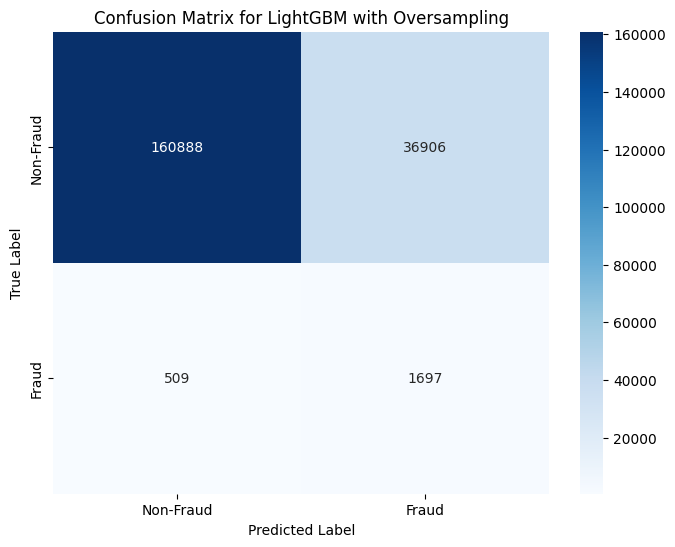

In [ ]:
cm_lgbm = confusion_matrix(y_test, y_pred_adjusted)
# 5. Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LightGBM with Oversampling')
plt.show()  

## Hyper Parameter Tunning

#### Bayesian Optimization (Optuna)

In [ ]:
import optuna
from lightgbm import LGBMClassifier as lgb
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    }
    
    # --- Build Pipeline: SMOTE + Classifier ---
    model = lgb(random_state = RANDOM_STATE)
    model.set_params(**params)
    smote_pipeline = ImbPipeline([
        
        ('resampler', SMOTE()),
        ('classifier', model)
    ])
    # --- Cross-Validation ---
    skf = StratifiedKFold(n_splits=3, shuffle= True, random_state=RANDOM_STATE)
    scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(
        smote_pipeline,
        X_train_preprocessed,
        y_train,
        scoring= scorer,
        cv= skf,
        n_jobs= -1
    )
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


[I 2025-01-10 12:57:18,896] A new study created in memory with name: no-name-bb7087c6-e084-434b-8c44-0083ad170b09
[I 2025-01-10 12:57:36,724] Trial 0 finished with value: 0.8667686354491181 and parameters: {'num_leaves': 75, 'max_depth': 9, 'learning_rate': 0.07469223063228352, 'subsample': 0.9784007510409554, 'colsample_bytree': 0.8902121654817391, 'lambda_l1': 4.1833496601121265, 'lambda_l2': 0.7562236879337636}. Best is trial 0 with value: 0.8667686354491181.
[I 2025-01-10 12:57:53,884] Trial 1 finished with value: 0.877965807857597 and parameters: {'num_leaves': 36, 'max_depth': 14, 'learning_rate': 0.11995095084703278, 'subsample': 0.7871711621163053, 'colsample_bytree': 0.7725484539476711, 'lambda_l1': 1.6132092018972322, 'lambda_l2': 3.422430959613992}. Best is trial 1 with value: 0.877965807857597.
[I 2025-01-10 12:58:08,740] Trial 2 finished with value: 0.875281474754507 and parameters: {'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.11270417566101053, 'subsample': 0.86

AttributeError: 'Study' object has no attribute 'best_params_'

In [ ]:
print("Best Parameters:", study.best_params)

Best Parameters: {'num_leaves': 23, 'max_depth': 15, 'learning_rate': 0.1753766368235759, 'subsample': 0.7332850088150694, 'colsample_bytree': 0.7851260467608571, 'lambda_l1': 0.5945840471601576, 'lambda_l2': 2.6519086625399213}


In [ ]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = lgb(**best_params)
final_pipeline = ImbPipeline([
    ('resampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', final_model)
])

final_pipeline.fit(X_train_preprocessed, y_train)

# Test set evaluation
y_pred_probs = final_pipeline.predict_proba(X_test_preprocessed)[:, 1]
y_pred = final_pipeline.predict(X_test_preprocessed)
roc_auc = roc_auc_score(y_test, y_pred_probs)
final_report = classification_report(y_test, y_pred)
print(f"Final Test ROC AUC: {roc_auc:.4f}")
print(f"Classofication report with best hyper param: {final_report}")


[LightGBM] [Warning] lambda_l1 is set=0.5945840471601576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5945840471601576
[LightGBM] [Warning] lambda_l2 is set=2.6519086625399213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6519086625399213
[LightGBM] [Warning] lambda_l1 is set=0.5945840471601576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5945840471601576
[LightGBM] [Warning] lambda_l2 is set=2.6519086625399213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6519086625399213
[LightGBM] [Info] Number of positive: 791177, number of negative: 791177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10031
[LightGBM] [Info] Number of data points in the train set: 1582354, number of used features: 49
[LightGBM] [Info] [binary:BoostFromSc

In [ ]:
optimal_threshold = 0.015  # Example threshold based on the curve
y_pred_adjusted = (y_pred_probs >= optimal_threshold).astype(int)

adjusted_report = classification_report(y_test, y_pred_adjusted)
print(f"Classification Report for LightGBM with Oversampling at 0.015 threshold:\n{adjusted_report}")


Classification Report for LightGBM with Oversampling at 0.015 threshold:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    197794
           1       0.04      0.81      0.08      2206

    accuracy                           0.79    200000
   macro avg       0.52      0.80      0.48    200000
weighted avg       0.99      0.79      0.87    200000

